In [381]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
print(tf.__version__)
import re
import os
import time
from tensorflow import keras

from tensorflow.keras.layers import Dense , Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split



2.6.4


In [382]:
EncoderLen=70
DecoderLen=70
Batch_Size= 128
Buffersize= Batch_Size*8


In [383]:
train_df= pd.read_csv("../input/hindienglish-corpora/Hindi_English_Truncated_Corpus.csv")


In [384]:
train_df.drop(['source'],axis=1,inplace=True)
mask= (train_df['english_sentence'].str.len()>20) &(train_df['english_sentence'].str.len()<200)
train_df=train_df.loc[mask]
train_df.head()


,english_sentence,hindi_sentence
0,politicians do not have permission to do what needs to be done.,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है ."
1,"I'd like to tell you about one such child,","मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,"
2,This percentage is even greater than the percentage in India.,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,what we really mean is that they're bad at not paying attention.,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,.The ending portion of these Vedas is called Upanishad.,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [385]:
pd.set_option('display.max_colwidth',None)
train_df.head()

,english_sentence,hindi_sentence
0,politicians do not have permission to do what needs to be done.,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है ."
1,"I'd like to tell you about one such child,","मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,"
2,This percentage is even greater than the percentage in India.,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,what we really mean is that they're bad at not paying attention.,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,.The ending portion of these Vedas is called Upanishad.,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [386]:
eng= train_df['english_sentence']
hind= train_df['hindi_sentence']
eng= eng.apply(lambda x: "<SOS> "+str(x)+" <EOS>")
hind=hind.apply(lambda x: "<SOS> "+x+" <EOS>")


In [387]:
filters= '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
token='<unk>'
eng_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters=filters,oov_token= token)
hind_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters=filters,oov_token=token)
eng_tokenizer.fit_on_texts(eng)
hind_tokenizer.fit_on_texts(hind)
inputs=eng_tokenizer.texts_to_sequences(eng)
targets=hind_tokenizer.texts_to_sequences(hind)

In [388]:
Encoder_Vocab = len(eng_tokenizer.word_index) + 1
Decoder_Vocab = len(hind_tokenizer.word_index) + 1
print(Encoder_Vocab, Decoder_Vocab)

56620 65824


In [389]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,maxlen=EncoderLen,padding='post',truncating='post')
targets= tf.keras.preprocessing.sequence.pad_sequences(targets,maxlen=DecoderLen,padding='post',truncating='post')
inputs=tf.cast(inputs, dtype= tf.int64)
targets= tf.cast(targets, dtype= tf.int64)


In [390]:
inputs

<tf.Tensor: shape=(107217, 70), dtype=int64, numpy=
array([[   2, 2945,   66, ...,    0,    0,    0],
       [   2, 1625,   63, ...,    0,    0,    0],
       [   2,   15, 2733, ...,    0,    0,    0],
       ...,
       [   2,   18,   14, ...,    0,    0,    0],
       [   2,   55, 2493, ...,    0,    0,    0],
       [   2, 3031,  125, ...,    0,    0,    0]])>

In [391]:
dataset= tf.data.Dataset.from_tensor_slices((inputs,targets)).shuffle(Buffersize).batch(Batch_Size)

In [392]:
def get_angles(position,i,d_model):
    angle_rates= 1/ np.power(10000, (2*(i//2)) / np.float32(d_model))
    return position * angle_rates
def positional_encoding(position,d_model):
    angle_rads= get_angles(
    np.arange(position)[:,np.newaxis],
    np.arange(d_model)[np.newaxis,:],
    d_model)
    
    angle_rads[: , 0::2 ]= np.sin(angle_rads[:, 0::2 ])
    angle_rads[: , 1::2 ]=np.cos(angle_rads[: , 1::2 ])
    
    pos_encoding= angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding , dtype=tf.float32)
    

(1, 50, 512)


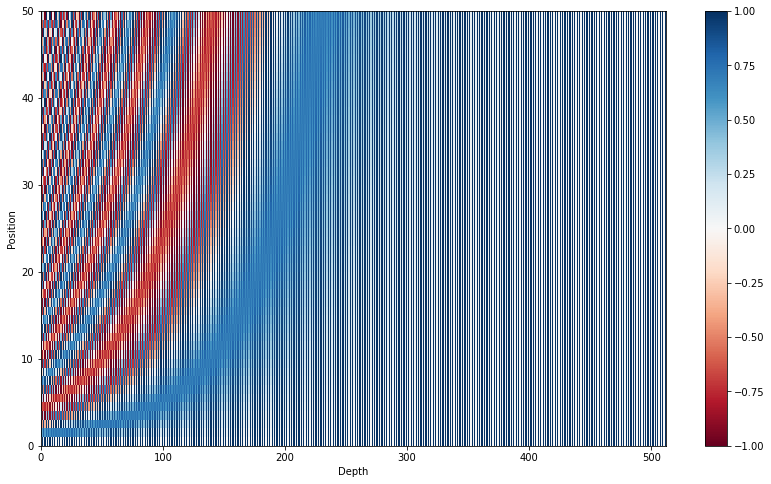

In [393]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)
plt.figure(figsize=(14,8))
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [394]:
def create_padding_mask(seq):
    seq= tf.cast(tf.math.equal(seq,0), tf.float32)
    return seq[:, tf.newaxis,tf.newaxis, :]

def create_look_ahead_mask(size):
    mask= 1 - tf.linalg.band_part(tf.ones((size,size)),-1,0)
    return mask

In [395]:
def scaled_dot_product_attention(q,k,v,mask):
    matmul_qk= tf.matmul(q,k,transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1],tf.float32)
    scaled_attention_logits= matmul_qk/ tf.math.sqrt(64*dk)
    
    if mask is not None:
        scaled_attention_logits += (mask* -1e9)
    
    attention_weights= tf.nn.softmax(scaled_attention_logits,axis=-1)
    
    output = tf.matmul(attention_weights,v)
    return output , attention_weights
    

In [396]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,*,d_model,num_heads):
        super(MultiHeadAttention,self).__init__()
        self.num_heads= num_heads
        self.d_model= d_model
        assert d_model % self.num_heads==0
        
        self.depth = d_model// self.num_heads
        
        self.wq= tf.keras.layers.Dense(d_model)
        self.wk= tf.keras.layers.Dense(d_model)
        self.wv= tf.keras.layers.Dense(d_model)
        
        self.dense= tf.keras.layers.Dense(d_model)
        
    def split_heads(self,x,batch_size):
        x= tf.reshape(x, (batch_size,-1,self.num_heads, self.depth))
        return tf.transpose(x,perm=[0,2,1,3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q=self.wq(q)
        k=self.wk(k)
        v=self.wv(v)
        
        q=self.split_heads(q, batch_size)
        k=self.split_heads(k, batch_size)
        v=self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q,k,v,mask)
        scaled_attention= tf.transpose(scaled_attention, perm=[0,2,1,3])
        concat_attention= tf.reshape(scaled_attention,(batch_size,-1,self.d_model))
        output=self.dense(concat_attention)
        
        return output, attention_weights


    

In [397]:
def point_wise_feed_forward_network(d_model,dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [398]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.fnn= point_wise_feed_forward_network(d_model,dff)
        
        self.layernorm1= tf.keras.layers.LayerNormalization(epsilon= 1e-6)
        self.layernorm2= tf.keras.layers.LayerNormalization(epsilon= 1e-6)
        
        self.dropout1= tf.keras.layers.Dropout(rate)
        self.dropout2= tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output= self.dropout1(attn_output , training=training)
        out1 =  self.layernorm1(x+ attn_output)
        
        ffn_output=self.fnn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2= self.layernorm2(out1 + ffn_output)
        
        return out2
        

In [399]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff,rate=0.1):
        super(DecoderLayer,self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        
        self.fnn= point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1= tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2= tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3= tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1= tf.keras.layers.Dropout(rate)
        self.dropout2= tf.keras.layers.Dropout(rate)
        self.dropout3= tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1= self.mha1(x,x,x,look_ahead_mask)
        attn1= self.dropout1(attn1, training= training)
        out1 = self.layernorm1(attn1+x)
        
        attn2, attn_weights_block2= self.mha1(enc_output,enc_output,out1,padding_mask)
        attn2= self.dropout2(attn2,training= training)
        out2=self.layernorm3(attn2+out1)
        
        ffn_output= self.fnn(out2)
        ffn_output= self.dropout3(ffn_output, training= training)
        out3= self.layernorm3(ffn_output+out2)
        
        return out3, attn_weights_block1,attn_weights_block2
        

In [400]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,*, num_layers, d_model, num_heads,dff, input_vocab_size,rate=0.1):
        
        super(Encoder, self).__init__()
        
        self.d_model= d_model
        self.num_layers= num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding= positional_encoding(128, self.d_model)
        
        self.enc_layers= [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]
        
        self.dropout= tf.keras.layers.Dropout(rate)
        
    def call(self ,x ,training,mask ):
        seq_len= tf.shape(x)[1]
        
        x=self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model,tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x= self.dropout(x, training= training)
        
        for i in range(self.num_layers):
            x= self.enc_layers[i](x, training, mask)
            
        return x
        

In [401]:
class Decoder(tf.keras.layers.Layer):
    
    def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model= d_model
        self.num_layers= num_layers
        
        self.embedding= tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(128, d_model)
        
        self.dec_layers= [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) 
                          for _ in range(num_layers)]
        self.dropout= tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len= tf.shape(x)[1]
        attention_weights= {}
        
        x=self.embedding(x)
        x*= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x+= self.pos_encoding[: , :seq_len, :]
        
        x= self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x,block1,block2= self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
            attention_weights['decoder_layer{}_block1'.format(i+1)]= block1
            attention_weights['decoder_layer{}_block2'.format(i+1)]=block2
            
        return x, attention_weights
        
    


In [413]:
class Transformer(tf.keras.Model):
    def __init__(self,num_layers,d_model,num_heads,dff,input_vocab_size,target_vocab_size,rate=0.1):
        super(Transformer,self).__init__()
        
        self.encoder= Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           input_vocab_size=input_vocab_size, rate=rate)
        self.decoder= Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, rate=rate)
        
        self.final_layer= tf.keras.layers.Dense(target_vocab_size)
        
    def call (self,inp,tar,training):
        padding_mask, look_ahead_mask=self.create_masks(inp,tar)
        enc_output= self.encoder(inp,training,padding_mask)
        
        dec_output,attention_weights=self.decoder(tar,enc_output,training,look_ahead_mask,padding_mask)
        
        final_output=self.final_layer(dec_output)
        
        return final_output, attention_weights
    def create_masks(self, inp, tar):
        padding_mask= create_padding_mask(inp)
        
        look_ahead_mask= create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask= create_padding_mask(tar)
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
        return padding_mask, look_ahead_mask

In [414]:
num_layers= 4
d_model= 128
dff=512
num_heads=8
dropout_rate=0.1
EPOCHS= 30


In [415]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule,self).__init__()
        
        self.d_model= tf.cast(d_model,tf.float32)
        self.warmup_steps= warmup_steps
        
    def __call__(self,step):
        arg1= tf.math.rsqrt(step)
        arg2= step*(self.warmup_steps** -1.5)
   
        return tf.math.rsqrt(self.d_model)* tf.math.minimum(arg1,arg2)
    

In [416]:
learning_rate = CustomSchedule(d_model)

optimizer= tf.keras.optimizers.Adam(learning_rate,beta_1=0.9,beta_2=0.98,epsilon=1e-9)

Text(0.5, 0, 'Train Step')

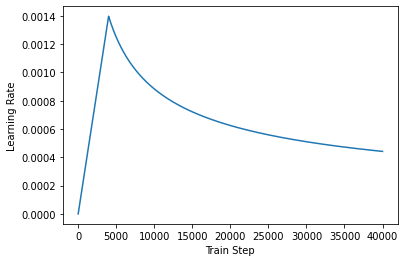

In [417]:
temp_learning_rate_schedule= CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype= tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel('Train Step')

In [418]:
loss_object= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True, reduction='none')
def loss_function(real,pred):
    mask= tf.math.logical_not(tf.math.equal(real,0))
    losss=loss_object(real,pred)
    
    mask=tf.cast(mask,dtype= losss.dtype)
    losss *= mask
    
    return tf.reduce_sum(losss)/tf.reduce_sum(mask)
    

In [419]:
def accuracy_function(real,pred):
    accuracies= tf.equal(real, tf.argmax(pred,axis=2))
    
    mask=tf.logical_not(tf.math.equal(real,0))
    accuracies= tf.math.logical_and(mask,accuracies)
    accuracies= tf.cast(accuracies, dtype= tf.float32)
    mask= tf.cast(mask,dtype= tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [420]:
train_loss= tf.keras.metrics.Mean(name= 'train_loss')
train_accuracy= tf.keras.metrics.Mean(name= 'train_accuracy')

In [421]:
transformer= Transformer(
    num_layers= num_layers,
    d_model=d_model,
    num_heads= num_heads,
    dff=dff,
    input_vocab_size= Encoder_Vocab,
    target_vocab_size= Decoder_Vocab,
    rate= dropout_rate
)

In [422]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp,tar):
    tar_inp= tar[:, : -1 ]
    tar_real=tar[:, 1: ]
    
   
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(
        inp, tar_inp,
        True,
        )
        loss= loss_function(tar_real,predictions)
        
    gradients= tape.gradient(loss,transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real,predictions))

# MODEL TRAINING

In [423]:
for epoch in range(EPOCHS):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    for(batch,(inp,tar)) in enumerate(dataset):
        train_step(inp,tar)
        
        if batch%100==0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {train_loss.result():.3f} Accuracy {train_accuracy.result():.4f}')
            
    print(f'Epoch {epoch+1} Loss {train_loss.result():.3f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time()-start} sec\n')
    
        

Epoch 1 Batch 0 Loss 11.105 Accuracy 0.0000
Epoch 1 Batch 100 Loss 10.999 Accuracy 0.0252
Epoch 1 Batch 200 Loss 10.727 Accuracy 0.0431
Epoch 1 Batch 300 Loss 10.318 Accuracy 0.0492
Epoch 1 Batch 400 Loss 9.839 Accuracy 0.0533
Epoch 1 Batch 500 Loss 9.393 Accuracy 0.0548
Epoch 1 Batch 600 Loss 9.054 Accuracy 0.0563
Epoch 1 Batch 700 Loss 8.785 Accuracy 0.0594
Epoch 1 Batch 800 Loss 8.554 Accuracy 0.0647
Epoch 1 Loss 8.478 Accuracy 0.0668
Time taken for 1 epoch: 296.598331451416 sec

Epoch 2 Batch 0 Loss 6.748 Accuracy 0.1123
Epoch 2 Batch 100 Loss 6.685 Accuracy 0.1220
Epoch 2 Batch 200 Loss 6.617 Accuracy 0.1290
Epoch 2 Batch 300 Loss 6.554 Accuracy 0.1341
Epoch 2 Batch 400 Loss 6.500 Accuracy 0.1382
Epoch 2 Batch 500 Loss 6.444 Accuracy 0.1422
Epoch 2 Batch 600 Loss 6.392 Accuracy 0.1457
Epoch 2 Batch 700 Loss 6.342 Accuracy 0.1488
Epoch 2 Batch 800 Loss 6.291 Accuracy 0.1521
Epoch 2 Loss 6.275 Accuracy 0.1532
Time taken for 1 epoch: 284.91356587409973 sec

Epoch 3 Batch 0 Loss 5.794

In [427]:
def evaluate(text):
    text= eng_tokenizer.texts_to_sequences([text])
  
    text= tf.keras.preprocessing.sequence.pad_sequences(text,maxlen=EncoderLen, padding='post',truncating = 'post')

    encoder_input= tf.expand_dims(text[0],0)
    
    decoder_input= [hind_tokenizer.word_index['<sos>']]
    output= tf.expand_dims(decoder_input,0)
    
    for i in range(DecoderLen):
        
        predictions, attention_weights= transformer(
        encoder_input,
        output,
        False
        )
        
        prediction= predictions[: , -1: ,:]
        predicted_id= tf.cast(tf.argmax(prediction,axis=-1), tf.int32)
        
        if predicted_id == hind_tokenizer.word_index['<eos>']:
            return tf.squeeze(output,axis=0),attention_weights
        
        output=tf.concat([output, predicted_id],axis=-1)
        
    return tf.squeeze(output,axis=0),attention_weights
    
    

In [428]:
def translate(eng_text):
    hind_text= evaluate(text=eng_text)[0].numpy()
    hind_text= np.expand_dims(hind_text[1:],0)
    return hind_tokenizer.sequences_to_texts(hind_text)[0]

# Prediction

In [429]:
translate("I am a student and I like to study very much.")

'मैं एक छात्र और छात्र के साथ इस विषय पर काम कर रहा हूँ'

In [430]:
translate("I want to play cricket")

'क्रिकेट में खेल मुझे क्रिकेट के खेल को पसंद कर सकते हैं।'

In [431]:
translate("I am happy")

'मैं खुश हूं खुश हूं खुश हूं मैं खुश हूं'